# How “good” is your model, and how can you make it better? 


What distinguishes “true artists” from “one-hit wonders” in machine learning is an understanding of how a model performs with respect to different data. This hands-on tutorial will show you how to use scikit-learn’s model evaluation functions to evaluate different models in terms of accuracy and generalisability, and search for optimal parameter configurations.

## 1. Load the required libraries

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cross_validation as cv

# Extra plotting functionality
import visplots

from sklearn import preprocessing, metrics 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy.stats.distributions import randint
from multilayer_perceptron import multilayer_perceptron

%matplotlib inline

## 2. Exploring and pre-processing data

The dataset we will be using throughout this workshop is an adapted version of the wine quality case study, available from the UCI Machine Learning repository at https://archive.ics.uci.edu/ml/datasets/Wine+Quality. The first thing you will need to do in order to work with the wine dataset is to read the contents from the provided wine.csv data file using the `read_csv` command:

In [2]:
wine   = pd.read_csv("data/wine.csv", sep=",")
header = wine.columns.values

At this point, you should try to explore the first few rows of the imported wine DataFrame using the "`head`" function from the `pandas` package (http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html):

In [3]:
### Write your code here ###

# Solution #
wine.head() 

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,high_quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,0
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,0
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,0
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,0
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,0


In order to feed the data into our classification models, the imported wine DataFrame needs to be converted into a `numpy` array. For more information on numpy arrays, see http://scipy-lectures.github.io/intro/numpy/array_object.html. Subsequently, we need to split our initial dataset into the data matrix X (independent variable) and the associated class vector y (dependent or target variable). 

In [4]:
# Convert to numpy array
npArray = np.array(wine)

X = npArray[:,:-1]
y = npArray[:,-1].astype(int)

It is always a good practice to check the dimensionality of the imported data prior to constructing any classification model to check that you really have imported all the data and imported it in the correct way (e.g. one common mistake is to get the separator wrong and end up with only one column). <br/> Try printing the size of the input matrix X and class vector y using the "`shape`" command: 

In [5]:
print "X dimensions:", ### Write your code here ###
print "y dimensions:", ### Write your code here ###

# Solution #
# print "X dimensions:", X.shape 
# print "y dimensions:", y.shape 

X dimensions: y dimensions:


Based on the class vector y, the wine samples are classified into two distinct categories: high quality (class 1) and low quality (class 0).
<br/><br/>An important thing to understand before applying any classification algorithms is how the output labels are distributed. Are they evenly distributed? Imbalances in distribution of labels can often lead to poor classification results for the minority class even if the classification results for the majority class are very good. For the purposes of this workshop, the ratio between the two classes has been kept constant.

In [6]:
yFreq = scipy.stats.itemfreq(y)
print yFreq

[[  0 500]
 [  1 500]]


It is usually advisable to scale your data prior to fitting a classification model. The main advantage of scaling is to avoid attributes of greater numeric ranges dominating those in smaller numeric ranges. For the purposes of this case study, we are applying auto-scaling on the whole X dataset. (Auto-scaling: mean-centering is initially applied per column, followed by scaling where the centered columns are divided by their standard deviation). 

Use as a reference the sklearn preprocessing documentation page in order to scale your data (http://scikit-learn.org/stable/modules/preprocessing.html)  

In [7]:
### Write your code here ###

# Solution #
# X = preprocessing.StandardScaler().fit_transform(X) 
X = preprocessing.scale(X)

You can visualise the relationship between two variables (features) using a simple scatter plot. This step can give you a good first indication of the ML model model to apply and its complexity (linear vs. non-linear). At this stage, let’s plot the first two variables against each other:

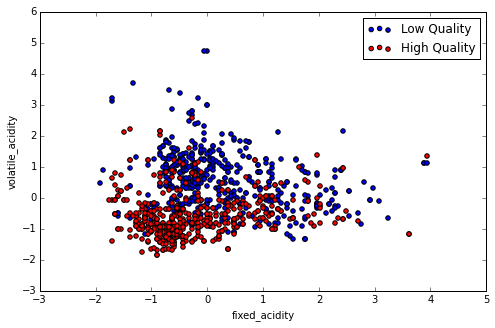

In [8]:
f0 = 0 
f1 = 1

plt.figure(figsize=(8, 5))
plt.scatter(X[y==0, f0], X[y==0, f1], color = 'b', edgecolors='black', label='Low Quality')
plt.scatter(X[y==1, f0], X[y==1, f1], color = 'r', edgecolors='black', label='High Quality')
plt.xlabel(header[f0])
plt.ylabel(header[f1])
plt.legend()
plt.show()

You can change the values of *f0* and *f1* to values of your own choice in order to investigate the relationship between different features. 

## 3. Training and testing a classifier

Training and testing a classification model on the same dataset is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data (poor generalisation). To use different datasets for training and testing, we need to split the wine dataset into two disjoint sets: train and test (**Holdout method**). <br/> 

In [9]:
XTrain, XTest, yTrain, yTest = cv.train_test_split(X, y, test_size= 0.3, random_state=1)

XTrain and yTrain are the two arrays you use to train your model. XTest and yTest are the two arrays that you use to evaluate your model. By default, scikit-learn splits the data so that 25% of it is used for testing, but you can also specify the proportion of data you want to use for training and testing (in this case, 30% is used for testing).

You can check the sizes of the different training and test sets by using the shape attribute:

In [10]:
print "XTrain dimensions:", XTrain.shape
print "yTrain dimensions:", yTrain.shape
print "XTest dimensions:",  XTest.shape
print "yTest dimensions:",  yTest.shape

XTrain dimensions: (700, 10)
yTrain dimensions: (700,)
XTest dimensions: (300, 10)
yTest dimensions: (300,)


## 4. KNN

To build KNN models using scikit-learn, you will be using the `KNeighborsClassifier` object, which allows you to set the value of K using the `n_neighbors` parameter (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). The optimal choice for the value K is highly data-dependent: in general a larger K suppresses the effects of noise, but makes the classification boundaries less distinct. <br/>

### 4.1 Uniform weights

For every classification model built with scikit-learn, we will follow four main steps: 1) Building the classification model (using either default, pre-defined or optimised parameters), 2) Training the model with data, 3) Testing the model, and 4) Evaluating and reporting on the model with performance metrics. <br/> <br/>

We are going to start by trying two predefined random values of K and compare their performance. Let us start with a small number of K such as K=3.

In [11]:
# Build the classifier 
knn3 = KNeighborsClassifier(n_neighbors=3)

# Train (fit) the model
knn3.fit(XTrain, yTrain)

# Test (predict)
yPredK3 = knn3.predict(XTest)

# Report the performance metrics
print metrics.classification_report(yTest, yPredK3)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredK3), 2)

             precision    recall  f1-score   support

          0       0.83      0.85      0.84       149
          1       0.85      0.83      0.84       151

avg / total       0.84      0.84      0.84       300

Overall Accuracy: 0.84


We can visualise the classification boundary created by the KNN classifier using the built-in function `visplots.knnDecisionPlot`. For easier visualisation, only the test samples are depicted in the plot. Remember though that the decision boundary has been built using the _training_ data! <br/> 

Help on function knnDecisionPlot in module visplots:

knnDecisionPlot(XTrain, yTrain, XTest, yTest, n_neighbors, weights)



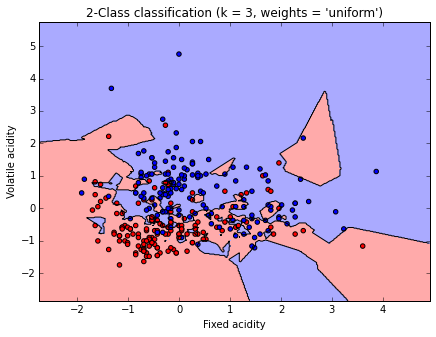

In [12]:
# Check the arguments of the function
help(visplots.knnDecisionPlot)

# Visualise the boundary
visplots.knnDecisionPlot(XTrain, yTrain, XTest, yTest, n_neighbors= 3, weights="uniform")

Let us try a larger value of K, for instance K = 99 or another number of your own choice; remember, it is good practice to select an *odd* number for K in a binary classification problem to avoid ties. Can you generate the KNN model and print the metrics for a larger K using as guidance the previous example? 

In [13]:
############################################  
# Write your code here 
# 1. Build the KNN classifier for larger K
# 2. Train (fit) the model
# 3. Test (predict)
# 4. Report the performance metrics
############################################


###  Solution ### 
knn99 = KNeighborsClassifier(n_neighbors=99)
knn99.fit(XTrain, yTrain)
yPredK99 = knn99.predict(XTest)

print metrics.classification_report(yTest, yPredK99)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredK99), 2)

             precision    recall  f1-score   support

          0       0.81      0.97      0.88       149
          1       0.97      0.77      0.86       151

avg / total       0.89      0.87      0.87       300

Overall Accuracy: 0.87


Visualise the boundaries as before using the K neighbors of your choice and the `knnDecisionPlot` command from  `visplots`. What do you observe? 

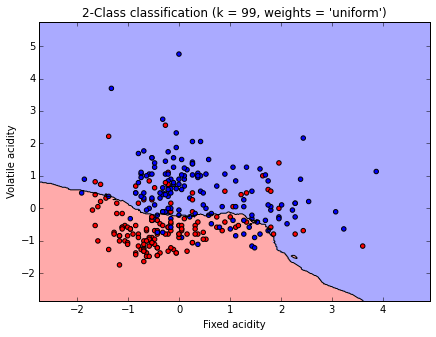

In [14]:
### Write your code here ### 

###  Solution ### 
visplots.knnDecisionPlot(XTrain, yTrain, XTest, yTest, n_neighbors= 99, weights="uniform")

** Answer: <BR/> For smaller values of K the decision boundaries present many "creases". In this case the models may suffer from instances of overfitting. For larger values of K, we can see that the decision boundaries are less distinct and tend towards linearity. In these cases the boundaries may be too simple and unable to learn thus leading to cases of underfitting. **

### 4.2 Distance weights

Under some circumstances, it is better to give more importance ("weight" in computing terms) to nearer neighbors. This can be accomplished through the `weights` parameter.  When `weights = 'distance'`, weights are assigned to the training data points in a way that is proportional to the inverse of the distance from the query point. In other words, nearer neighbors contribute more to the fit. <br/>

What if we use weights based on distance? Does it improve the overall performance?

In [15]:
# Build the classifier with two parameters
knnW3 = KNeighborsClassifier(n_neighbors=3, weights='distance')

# Train (fit) the model
knnW3.fit(XTrain, yTrain)

# Test (predict)
predictedW3 = knnW3.predict(XTest)

# Report the performance metrics
print metrics.classification_report(yTest, predictedW3)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, predictedW3), 2)

             precision    recall  f1-score   support

          0       0.85      0.87      0.86       149
          1       0.87      0.85      0.86       151

avg / total       0.86      0.86      0.86       300

Overall Accuracy: 0.86


### 4.3 Tuning KNN 

Rather than trying one-by-one predefined values of K, we can automate this process. The scikit-learn library provides the grid search function `GridSearchCV` (http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html), which allows us to exhaustively search for the optimum combination of parameters by evaluating models trained with a particular algorithm with all provided parameter combinations. Further details and examples on grid search with scikit-learn can be found at http://scikit-learn.org/stable/modules/grid_search.html <br/>

You can use the `GridSearchCV` function with the validation technique of your choice (in this example, 10-fold cross-validation has been applied) to search for a parametisation of the KNN algorithm that gives a more optimal model:

In [16]:
# Define the parameters to be optimised and their values/ranges
n_neighbors = np.arange(1, 51, 2)  # odd numbers of neighbors used
weights     = ['uniform','distance']

# Construct a dictionary of hyperparameters
parameters = [{'n_neighbors': n_neighbors, 'weights': weights}]

# Conduct a grid search with 10-fold cross-validation using the dictionary of parameters
grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=10)
grid.fit(XTrain, yTrain)

# Print the optimal parameters
bestNeighbors = grid.best_params_['n_neighbors'] 
bestWeight    = grid.best_params_['weights']

print "Best parameters found: n_neighbors=", bestNeighbors, "and weight=", bestWeight

Best parameters found: n_neighbors= 15 and weight= distance


<br/> Let us graphically represent the results of the grid search using a heatmap:

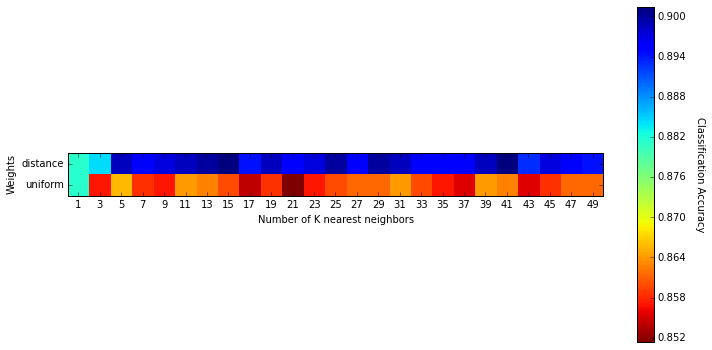

In [17]:
# grid_scores_ contains parameter settings and scores
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(n_neighbors), len(weights))
scores = np.transpose(scores)

# Make a heatmap with the performance
plt.figure(figsize=(12, 6))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap=plt.cm.get_cmap('jet_r'))
plt.xticks(np.arange(len(n_neighbors)), n_neighbors)
plt.yticks(np.arange(len(weights)), weights)
plt.xlabel('Number of K nearest neighbors')
plt.ylabel('Weights')

# Add the colorbar
cbar = plt.colorbar()
cbar.set_label('Classification Accuracy', rotation=270, labelpad=20)

plt.show()

When evaluating the resulting model it is important to do it on held-out samples that were not seen during the grid search process (XTest). <Br/>
So, we are testing our independent XTest dataset using the optimised model:

In [18]:
# Build the classifier using the optimal parameters detected by grid search 
knn = KNeighborsClassifier(n_neighbors = bestNeighbors, weights = bestWeight)

# Train (fit) the model
knn.fit(XTrain, yTrain)

# Test (predict)
yPredKnn = knn.predict(XTest)

# Report the performance metrics
print metrics.classification_report(yTest, yPredKnn)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredKnn), 2)

             precision    recall  f1-score   support

          0       0.86      0.91      0.89       149
          1       0.91      0.85      0.88       151

avg / total       0.88      0.88      0.88       300

Overall Accuracy: 0.88


#### Randomized search on hyperparameters
Unlike `GridSearchCV`, `RandomizedSearchCV` does not exhaustively try all the parameter settings. Instead, it samples a fixed number of parameter settings based on the distributions you specify (e.g. you might specify that one parameter should be sampled uniformly while another is sampled following a Gaussian distribution). The number of parameter settings that are tried is given by `n_iter`. If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used. You should use continuous distributions for continuous parameters. Further details can be found at http://scikit-learn.org/stable/modules/grid_search.html

Best parameters: n_neighbors= 3


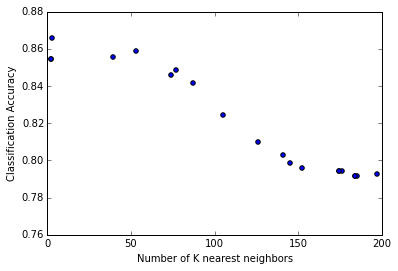

In [19]:
param_dist = {'n_neighbors': randint(1,200)}
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=20)
random_search.fit(XTrain, yTrain)

print "Best parameters: n_neighbors=", random_search.best_params_['n_neighbors']

neig = [score_tuple[0]['n_neighbors'] for score_tuple in random_search.grid_scores_]
res = [score_tuple[1] for score_tuple in random_search.grid_scores_]
plt.scatter(neig, res)
plt.xlabel('Number of K nearest neighbors')
plt.ylabel('Classification Accuracy')
plt.xlim(0,200)
plt.show()

## 5. Get your hands dirty

Choose a machine learning algorithm that you are familiar with or interested to learn about, and apply the four-step method introduced above to train, test, evaluate and tune a model. Towards the end of the session you get a chance to share your results.

### 5.1 Random Forests

The random forests model is an `ensemble method` since it aggregates a group of decision trees into an ensemble (http://scikit-learn.org/stable/modules/ensemble.html). Ensemble learning involves the combination of several models to solve a single prediction problem. It works by generating multiple classifiers/models which learn and make predictions independently. Those predictions are then combined into a single (mega) prediction that should be as good or better than the prediction made by any one classifer. Unlike single decision trees which are likely to suffer from high Variance or high Bias (depending on how they are tuned) Random Forests use averaging to find a natural balance between the two extremes. <br/> 

Let us start by building a simple Random Forest model using the default parameters. For further details and examples on how to construct a Random Forest, see http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [20]:
#############################################################   
# Write your code here 
# 1. Build the RF classifier using the default parameters
# 2. Train (fit) the model
# 3. Test (predict)
# 4. Report the performance metrics
#############################################################

## Solution ## 
clf = RandomForestClassifier()
clf.fit(XTrain, yTrain)
predRF = clf.predict(XTest)

print metrics.classification_report(yTest, predRF)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, predRF),2)

             precision    recall  f1-score   support

          0       0.83      0.94      0.88       149
          1       0.93      0.81      0.87       151

avg / total       0.88      0.88      0.88       300

Overall Accuracy: 0.88


We can visualise the classification boundary created by the linear SVM using the `visplots.rfDecisionPlot` function. You can check the arguments passed in this function by using the `help` command. For easier visualisation, only the test samples have been included in the plot. And remember that the decision boundary has been built using the _training_ data!

Help on function rfDecisionPlot in module visplots:

rfDecisionPlot(XTrain, yTrain, XTest, yTest)



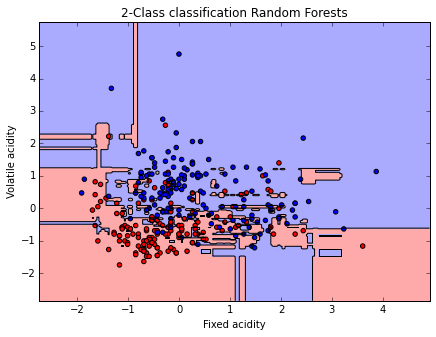

In [22]:
# Check the arguments of the function
help(visplots.rfDecisionPlot)

### Write your code here ### 

###  Solution ### 
visplots.rfDecisionPlot(XTrain, yTrain, XTest, yTest)

#### Tuning for Random Forests

Random forests offer several parameters that can be tuned. In this case, parameters such as `n_estimators`, `max_features`, `max_depth` and `min_samples_leaf` can be some of the parameters to be optimised. 

In [ ]:
##### TO BE FIXED!!! ##### 

# Define the parameters to be optimised and their values/ranges

parameters = [{"n_estimators": [250, 500, 1000]}]
sample_leaf_options = [1,5,10,50,100,200,500]

###### WHAT ELSE DO WE ADD HERE?!?!?!!? ###### 

##### DO WE TUNE WITH A GRID SEARCH??? ##### 


Finally, testing our independent XTest dataset using the optimised model: 

In [ ]:
####################################################################################  
# Write your code here 
# 1. Build the classifier using the optimal parameters detected by grid search 
# 2. Train (fit) the model
# 3. Test (predict)
# 4. Report the performance metrics
####################################################################################  


## WE HAVE NO SOLUTION

### 5.2 Support Vector Machines (SVMs)

SVMs attempt to build a decision boundary that accurately separates the samples of different classes by *maximizing* the margin between them.

#### Linear SVMs

The hyperparameter `C`, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low `C` tolerates training misclassifications and allows softer margins, while for high `C` the misclassifications become more significant leading to hard-margin SVMs and potentially cases of overfitting. 

At first, let us build a linear SVM model using the default value for the hypeparameter `C` (`C=1.0`). Thorough documentation on how to implement SVMs with scikit-learn can be found at http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [23]:
################################################################### 
# Write your code here 
# 1. Build a linear SVM classifier using the default parameters
# 2. Train (fit) the model
# 3. Test (predict)
# 4. Report the performance metrics
##################################################################

## Solution ## 
linearSVM = SVC(kernel='linear', C=1.0)
linearSVM.fit(XTrain, yTrain)
yPredLinear = linearSVM.predict(XTest)

print metrics.classification_report(yTest, yPredLinear)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredLinear),2)

             precision    recall  f1-score   support

          0       0.88      0.90      0.89       149
          1       0.90      0.87      0.89       151

avg / total       0.89      0.89      0.89       300

Overall Accuracy: 0.89


We can visualise the classification boundary created by the linear SVM using the `visplots.svmDecisionPlot` function. You can check the arguments passed in this function by using the `help` command. For easier visualisation, only the test samples have been included in the plot. And remember that the decision boundary has been built using the _training_ data!

Help on function svmDecisionPlot in module visplots:

svmDecisionPlot(XTrain, yTrain, XTest, yTest, kernel)



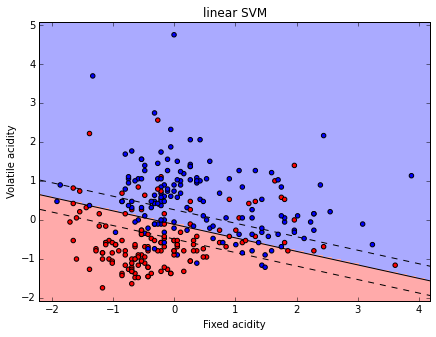

In [24]:
# Check the arguments of the function
help(visplots.svmDecisionPlot)

### Write your code here ### 


###  Solution ### 
visplots.svmDecisionPlot(XTrain, yTrain, XTest, yTest, 'linear')

**Tuning:** For more details and examples on how to tune linear SVM models using grid search and cross-validation you can use as a reference the following link: http://scikit-learn.org/stable/modules/grid_search.html

#### Non-linear (RBF) SVMs

In addition to C, which is common for all types of SVM, the gamma hyperparameter in the RBF kernel controls the nonlinearity of the SVM bounaries. The larger the gamma, the more nonlinear the boundaries surrounding individual samples. Lower values of gamma lead to broader, more linear boundaries. <br/><br/>  

At first, let us build an RBF SVM model using the default values for the hypeparameters `C` (`C=1.0`) and `gamma` (`gamma=0.0`). Thorough documentation on how to implement SVMs with scikit-learn can be found at http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [25]:
#################################################################  
# Write your code here 
# 1. Build the RBF SVM classifier using the default parameters
# 2. Train (fit) the model
# 3. Test (predict)
# 4. Report the performance metrics
################################################################# 

## Solution ## 
rbfSVM = SVC(kernel='rbf', C=1.0, gamma=0.0)
rbfSVM.fit(XTrain, yTrain)
yPredRBF = rbfSVM.predict(XTest)

print metrics.classification_report(yTest, yPredRBF)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredRBF),2)

             precision    recall  f1-score   support

          0       0.83      0.91      0.87       149
          1       0.91      0.82      0.86       151

avg / total       0.87      0.87      0.87       300

Overall Accuracy: 0.87


We can visualise the classification boundary created by the RBF SVM using the `visplots.svmDecisionPlot` function. You can check the arguments passed in this function by using the `help` command. For easier visualisation, only the test samples have been included in the plot. And remember that the decision boundary has been built using the _training_ data!

Help on function svmDecisionPlot in module visplots:

svmDecisionPlot(XTrain, yTrain, XTest, yTest, kernel)



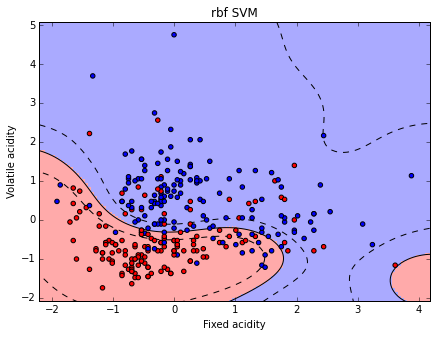

In [26]:
# Check the arguments of the function
help(visplots.svmDecisionPlot)

### Write your code here ### 

###  Solution ### 
visplots.svmDecisionPlot(XTrain, yTrain, XTest, yTest, 'rbf')

#### Hyperparameter Tuning for non-linear SVMs

Proper choice of `C` and `gamma` is critical for the performance of SVMs. Optimisation (tuning) of the hyperparameters can be achieved by applying a coarse tuning (often followed by a finer-tuning in the "neighborhood" of good parameters)

In [27]:
# Define the parameters to be optimised and their values/ranges
# Range for gamma and Cost hyperparameters
g_range = 2. ** np.arange(-15, 5, step=2)
C_range = 2. ** np.arange(-5, 15, step=2)

##############################################################################################  
# Write your code here 
# 1. Construct a dictionary of hyperparameters (see task 4.3)
# 2. Conduct a grid search with 10-fold cross-validation using the dictionary of parameters
# 3. Print the optimal parameters (don't forget to use np.log2() this time)
############################################################################################## 


# Solution 
parameters = [{'gamma': g_range, 'C': C_range}] 

grid = GridSearchCV(SVC(), parameters, cv= 10)  
grid.fit(XTrain, yTrain)

bestG = grid.best_params_['gamma']
bestC = grid.best_params_['C']
print "The best parameters are: gamma=", np.log2(bestG), " and Cost=", np.log2(bestC)


The best parameters are: gamma= -9.0  and Cost= 9.0


Plot the results of the grid search using a heatmap (see task 4.3).

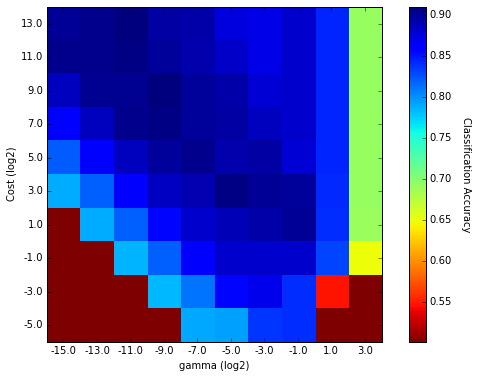

In [31]:
##########################################
# Write your code here 
# 1. Fix the scores 
# 2. Make a heatmap with the performance
# 3. Add the colorbar
##########################################



###  Solution ### 
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(g_range))

plt.figure(figsize=(10, 6))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap=plt.cm.get_cmap('jet_r'))
plt.xticks(np.arange(len(g_range)), np.log2(g_range))
plt.yticks(np.arange(len(C_range)), np.log2(C_range))
plt.xlabel('gamma (log2)')
plt.ylabel('Cost (log2)')

cbar = plt.colorbar()
cbar.set_label('Classification Accuracy', rotation=270, labelpad=20)
plt.show()


Finally, testing our independent XTest dataset using the optimised model: 

In [32]:
####################################################################################  
# Write your code here 
# 1. Build the classifier using the optimal parameters detected by grid search 
# 2. Train (fit) the model
# 3. Test (predict)
# 4. Report the performance metrics
####################################################################################  


## Solution ## 
rbfSVM = SVC(kernel='rbf', C = bestC, gamma = bestG)
rbfSVM.fit(XTrain, yTrain)
predictions = rbfSVM.predict(XTest) 

print metrics.classification_report(yTest, predictions)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, predictions),2)

             precision    recall  f1-score   support

          0       0.87      0.88      0.87       149
          1       0.88      0.87      0.87       151

avg / total       0.87      0.87      0.87       300

Overall Accuracy: 0.87


### 5.3 Logistic Regression

Logistic regression is based on linear regression, but rather than the predicted output being a continuous value, it predicts the probability that a sample belongs to a class based on the values of the input variables. In the case of classification, we can use this to then assign the sample to the most likely class. For more details, see: http://www.omidrouhani.com/research/logisticregression/html/logisticregression.htm 

In scikit-learn, you can learn a logistic regression model using the LogisticRegression object (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). As with linear regression, there are certain assumpttions that you might make or constraints that you wish your model to fulfil, e.g. whether or not you want a constant to be included in the function. You can also specify the way you wish learning to take place by using different solvers or how you wish errors to be penalised.

In [33]:
#############################################################################
# Write your code here 
# 1. Build the Logistic Regression classifier using the default parameters
# 2. Train (fit) the model
# 3. Test (predict)
# 4. Report the performance metrics
#############################################################################

## Solution ## 
l_regression = LogisticRegression()
l_regression.fit(XTrain, yTrain)
l_prediction = l_regression.predict(XTest)

print metrics.classification_report(yTest, l_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, l_prediction),2)

             precision    recall  f1-score   support

          0       0.89      0.89      0.89       149
          1       0.89      0.89      0.89       151

avg / total       0.89      0.89      0.89       300

Overall Accuracy: 0.89


We can visualise the classification boundary created by the logistic regression model using the built-in function `visplots.logregDecisionPlot`. <br/> As with the above examples, only the test samples have been included in the plot. Remember that the decision boundary has been built using the _training_ data!

Help on function logregDecisionPlot in module visplots:

logregDecisionPlot(XTrain, yTrain, XTest, yTest, pen_val='l2', c_val=10)



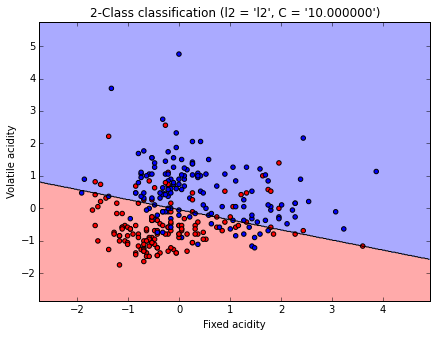

In [34]:
# Check the arguments of the function
help(visplots.logregDecisionPlot)

### Write your code here ### 

## Solution ## 
visplots.logregDecisionPlot(XTrain, yTrain, XTest, yTest)

#### Tuning Logistic Regression

Two hyperparameters that are often tuned for logistic regression models are the norm used in penalisation (`penalty`), which can be either `l1` or `l2` (default `l2`) and the inverse of regularisation strength, `C` (default `1.0`). 

In [35]:
# Define the parameters to be optimised and their values/ranges
# Range for pen and C hyperparameters
pen = ['l1','l2']
C_range = 2. ** np.arange(-5, 15, step=2)


##############################################################################################  
# Write your code here 
# 1. Construct a dictionary of hyperparameters (see task 4.3)
# 2. Conduct a grid search with 10-fold cross-validation using the dictionary of parameters
# 3. Print the optimal parameters
############################################################################################## 


# Solution
parameters = [{'C': C_range, 'penalty': pen}]

grid = GridSearchCV(LogisticRegression(), parameters, cv= 10)
grid.fit(XTrain, yTrain)

bestC = grid.best_params_['C']
bestP = grid.best_params_['penalty']
print "The best parameters are: cost=", bestC , " and penalty=", bestP

The best parameters are: cost= 0.5  and penalty= l1


Plot the results of the grid search with a heatmap (see task 4.3)

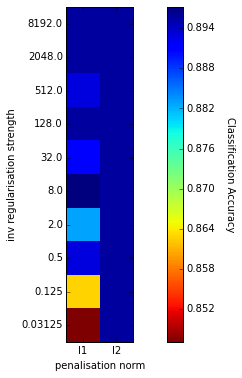

In [36]:
##########################################
# Write your code here 
# 1. Fix the scores 
# 2. Make a heatmap with the performance
# 3. Add the colorbar
##########################################


# Solution
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(pen), len(C_range))
scores = np.transpose(scores)

plt.figure(figsize=(12, 6))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap=plt.cm.get_cmap('jet_r'))
plt.xticks(np.arange(len(pen)), pen)
plt.yticks(np.arange(len(C_range)), C_range)
plt.xlabel('penalisation norm')
plt.ylabel('inv regularisation strength')

cbar = plt.colorbar()
cbar.set_label('Classification Accuracy', rotation=270, labelpad=20)

plt.show()

Finally, testing our independent XTest dataset using the optimised model: 

In [37]:
####################################################################################  
# Write your code here 
# 1. Build the classifier using the optimal parameters detected by grid search 
# 2. Train (fit) the model
# 3. Test (predict)
# 4. Report the performance metrics
####################################################################################  


## Solution ## 
l_regression = LogisticRegression(C=bestC, penalty=bestP)
l_regression.fit(XTrain, yTrain)
l_prediction = l_regression.predict(XTest)

print metrics.classification_report(yTest, l_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, l_prediction),2)

             precision    recall  f1-score   support

          0       0.88      0.89      0.89       149
          1       0.89      0.88      0.89       151

avg / total       0.89      0.89      0.89       300

Overall Accuracy: 0.89


For more details on cross-validating and tuning logistic regression models, see: <br/>
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
and <br/>
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### 5.4 Neural Networks

A neural network is a set of connected input-output units. During training, the connections are assigned different weights. This allows the classification function to take on highly complex "shapes" (equivalent to complicated mathematical expressions that go beyond the linear or polynomial models of logistic regression). This might also mean that the resulting model is difficult to interpret and map to domain knowledge. (NB. even though you might think of the second layer of a neural network as just a logistic regression model, the non-linear transformation in the hidden units gives the input to output mapping a non-linear decision boundary.)
<br/> 

We will build our Neural Network classifier using the `multilayer_perceptron.MultilayerPerceptronClassifier` function. Further details on the `multilayer_perceptron` library can be found at https://github.com/IssamLaradji/NeuralNetworks. 

In [38]:
help(multilayer_perceptron.MultilayerPerceptronClassifier)

Help on class MultilayerPerceptronClassifier in module multilayer_perceptron.multilayer_perceptron:

class MultilayerPerceptronClassifier(BaseMultilayerPerceptron, sklearn.base.ClassifierMixin)
 |  Multi-layer Perceptron classifier.
 |  
 |  This algorithm optimizes the logistic loss function using l-bfgs or
 |  gradient descent.
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
 |      The ith index in list contains the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'logistic', 'tanh', 'relu'}, default 'relu'
 |      Activation function for the hidden layer.
 |  
 |      -  'logistic', the logistic sigmoid function,
 |          returns f(x) = 1 / (1 + exp(x)).
 |  
 |      - 'tanh', the hyperbolic tan function,
 |         returns f(x) = tanh(x).
 |  
 |      - 'relu', the rectified linear unit function,
 |         returns f(x) = max(0, x)
 |  
 |  algorithm : {'l-bfgs', 'sgd'}, default 'l-bfgs'
 |      T

In [39]:
#####################################################################################  
# Write your code here 
# 1. Build the Neural Net classifier classifier ... you can use parameters such as 
#    activation='logistic', hidden_layer_sizes=2, learning_rate_init=.5
# 2. Train (fit) the model
# 3. Test (predict)
# 4. Report the performance metrics
#####################################################################################


# Solution #
nnet = multilayer_perceptron.MultilayerPerceptronClassifier(activation='logistic', 
                                                            hidden_layer_sizes=2, learning_rate_init=.5)
nnet.fit(XTrain, yTrain)
net_prediction = nnet.predict(XTest)

print metrics.classification_report(yTest, net_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, net_prediction),2)

             precision    recall  f1-score   support

          0       0.87      0.87      0.87       149
          1       0.87      0.87      0.87       151

avg / total       0.87      0.87      0.87       300

Overall Accuracy: 0.87


We can visualise the classification boundary of the neural network using the built-in visualisation function `visplots.nnDecisionPlot`. As with the above examples, only the test samples have been included in the plot. And remember that the decision boundary has been built using the _training_ data!

Help on function nnDecisionPlot in module visplots:

nnDecisionPlot(XTrain, yTrain, XTest, yTest, hidden_layer, learning_rate)



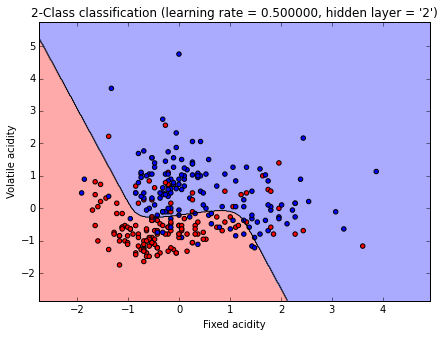

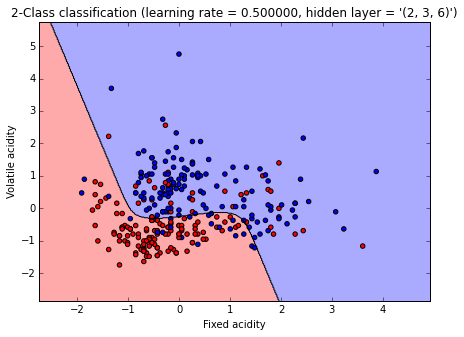

In [40]:
# Check the arguments of the function
help(visplots.nnDecisionPlot)

### Write your code here ###
### Try arguments such as hidden_layer = 2 or (2,3,6) and learning_rate = .5


# Solution #
visplots.nnDecisionPlot(XTrain, yTrain, XTest, yTest, 2, .5)
visplots.nnDecisionPlot(XTrain, yTrain, XTest, yTest, (2,3,6), .5)

#### Tuning Neural Nets 

Neural networks have many hyperparameters, all of which could potentially be tuned, including learning rate, loss function, number of training iterations, number of hidden layers and number of units within each of them, nonlinearity function, and weight initialisation. 

Here's a worked through example which explores the set of parameter configurations with different numbers of hidden layers and units within them (`hidden_layer_sizes`), and learning rates (`learning_rate_init`).

Note the syntax to specify the number of hidden layers and units with them. If a tuple is given, each value in the tuple stands for the number of units in a layer, e.g. the tuple `(2,3,4)` would mean a network with two units in the first layer, three units in the second, and four in the third. If a single value is given, then there is only one hidden layer, and the value stands for the number of units in this layer.

In [41]:
# Define the parameters to be optimised and their values/ranges
# Range for gamma and Cost hyperparameters
layer_size_range = [(3,2),(10,10),(2,2,2),10,5] # different networks shapes
learning_rate_range = np.linspace(.1,1,3)


##############################################################################################  
# Write your code here 
# 1. Construct a dictionary of hyperparameters (see task 4.3)
# 2. Conduct a grid search with 10-fold cross-validation using the dictionary of parameters
# 3. Print the optimal parameters
############################################################################################## 


# Solution
parameters = [{'hidden_layer_sizes': layer_size_range, 'learning_rate_init': learning_rate_range}]

grid = GridSearchCV(multilayer_perceptron.MultilayerPerceptronClassifier(), parameters, cv= 10)
grid.fit(XTrain, yTrain)

best_size    = grid.best_params_['hidden_layer_sizes']
best_best_lr = grid.best_params_['learning_rate_init']
print "The best parameters are: hidden_layer_sizes=", best_size, " and learning_rate_init=", best_best_lr

The best parameters are: hidden_layer_sizes= 5  and learning_rate_init= 1.0


Plot the results of the grid search using a heatmap (see task 4.3).

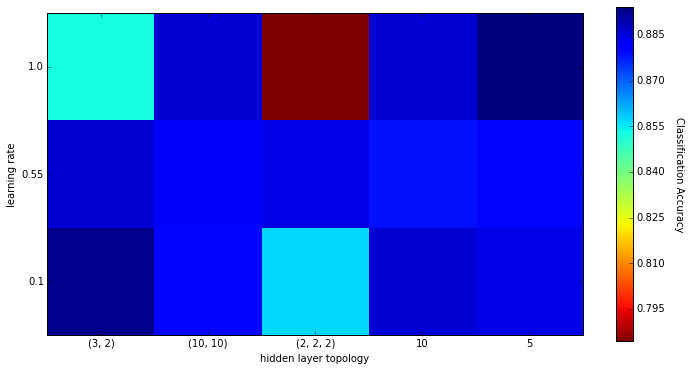

In [42]:
##########################################
# Write your code here 
# 1. Fix the scores 
# 2. Make a heatmap with the performance
# 3. Add the colorbar
##########################################


# Solution
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(layer_size_range), len(learning_rate_range))
scores = np.transpose(scores)

plt.figure(figsize=(12, 6))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap=plt.cm.get_cmap('jet_r'))
plt.xticks(np.arange(len(layer_size_range)), layer_size_range)
plt.yticks(np.arange(len(learning_rate_range)), learning_rate_range)
plt.xlabel('hidden layer topology')
plt.ylabel('learning rate')

cbar = plt.colorbar()
cbar.set_label('Classification Accuracy', rotation=270, labelpad=20)

plt.show()

Finally, testing our independent XTest dataset using the optimised model: 

In [43]:
####################################################################################  
# Write your code here 
# 1. Build the classifier using the optimal parameters detected by grid search 
# 2. Train (fit) the model
# 3. Test (predict)
# 4. Report the performance metrics
####################################################################################  


## Solution ## 
nnet = multilayer_perceptron.MultilayerPerceptronClassifier(hidden_layer_sizes=best_size, learning_rate_init=best_best_lr)
nnet.fit(XTrain, yTrain)
net_prediction = nnet.predict(XTest)

print metrics.classification_report(yTest, net_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, net_prediction),2)

             precision    recall  f1-score   support

          0       0.89      0.89      0.89       149
          1       0.89      0.89      0.89       151

avg / total       0.89      0.89      0.89       300

Overall Accuracy: 0.89


- *So, what is your best technique and why?*